<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
C:\Users\wys39\AppData\Local\Temp\ipykernel_10564\1222945988.py:13: SyntaxWarning: invalid escape sequence '\d'
  file_path = "D:\datascienEO\merged_data_our3months_6bands_3x3.geojson"  # <-- Update this with your actual file path


Epoch 1/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2299 - loss: 2.8711 - val_accuracy: 0.2373 - val_loss: 2.7052
Epoch 2/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2519 - loss: 2.6673 - val_accuracy: 0.2373 - val_loss: 2.6087
Epoch 3/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2562 - loss: 2.5856 - val_accuracy: 0.2373 - val_loss: 2.5762
Epoch 4/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2483 - loss: 2.5646 - val_accuracy: 0.2373 - val_loss: 2.5660
Epoch 5/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2533 - loss: 2.5494 - val_accuracy: 0.2373 - val_loss: 2.5616
Epoch 6/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2552 - loss: 2.5475 - val_accuracy: 0.2373 - val_loss: 2.5592
Epoch 7/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2480 - loss: 2.5610 - val_accuracy: 0.2373 - val_loss: 2.5578
Epoch 8/30
748/748 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2482 - loss: 2.5460 - val_accuracy: 0.

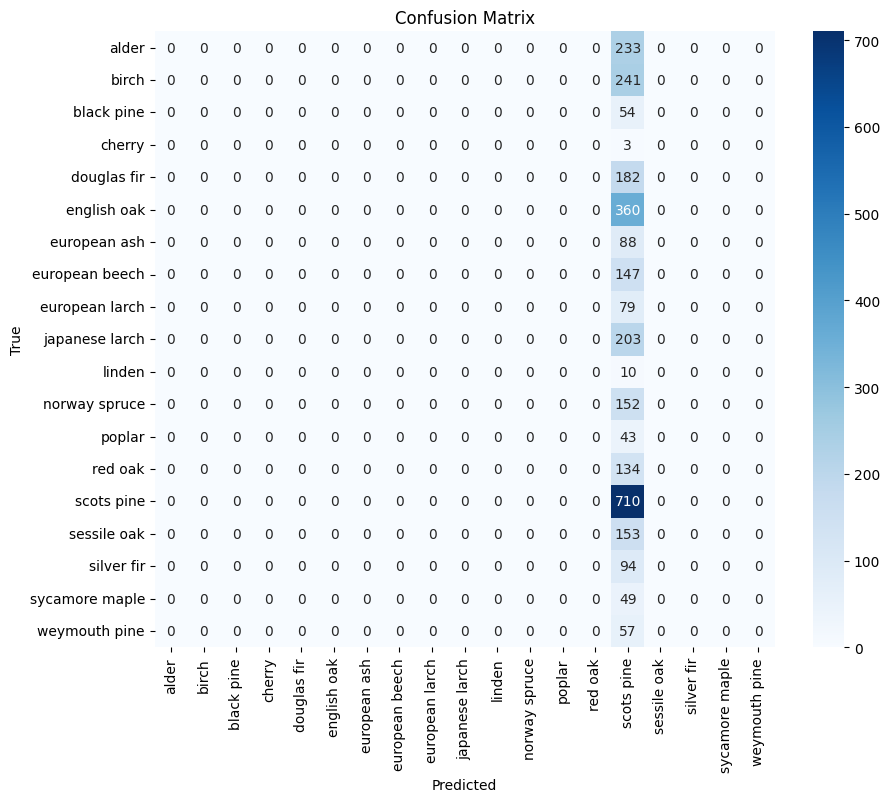

C:\Users\wys39\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wys39\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wys39\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                precision    recall  f1-score   support

         alder       0.00      0.00      0.00       233
         birch       0.00      0.00      0.00       241
    black pine       0.00      0.00      0.00        54
        cherry       0.00      0.00      0.00         3
   douglas fir       0.00      0.00      0.00       182
   english oak       0.00      0.00      0.00       360
  european ash       0.00      0.00      0.00        88
european beech       0.00      0.00      0.00       147
european larch       0.00      0.00      0.00        79
japanese larch       0.00      0.00      0.00       203
        linden       0.00      0.00      0.00        10
 norway spruce       0.00      0.00      0.00       152
        poplar       0.00      0.00      0.00        43
       red oak       0.00      0.00      0.00       134
    scots pine       0.24      1.00      0.38       710
   sessile oak       0.00      0.00      0.00       153
    silver fir       0.00      0.00      0.00  

In [3]:
import numpy as np
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, Flatten, Dense, Dropout, GlobalAveragePooling3D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

# Load GeoJSON dataset
file_path = "D:\datascienEO\merged_data_our3months_6bands_3x3.geojson"  # <-- Update this with your actual file path
with open(file_path, "r") as f:
    data = json.load(f)

# Extract features (grouped by spatial point with multiple months)
sites = {}

expected_bands = [f"{band}_{month}" for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"] for band in ["B4", "B8", "B11", "NDVI"]]

for feature in data["features"]:
    props = feature["properties"]
    site_id = props.get("id", "unknown")  # Unique identifier for a spatial point
    
    if site_id not in sites:
        sites[site_id] = {"bands": {key: [] for key in expected_bands}, "label": props.get("l3_species", "unknown")}
    
    # Extract bands for each month
    for key in expected_bands:
        if key in props and props[key] is not None:
            sites[site_id]["bands"][key].append(props[key])

# Convert dataset to structured arrays
features = []
labels = []

for site_id, values in sites.items():
    feature_vector = []
    for band in expected_bands:
        if len(values["bands"][band]) > 0:
            feature_vector.append(np.mean(values["bands"][band]))  # Average over time
        else:
            feature_vector.append(0)  # Default value for missing bands
    
    features.append(feature_vector)
    labels.append(values["label"])

X = np.array(features)
y = np.array(labels)

# Check for empty dataset
if X.shape[1] == 0:
    raise ValueError("No valid features were extracted. Check dataset structure.")

# Normalize Data to match ImageNet distribution (0-255 scaling)
scaler = MinMaxScaler(feature_range=(0, 255))
X = scaler.fit_transform(X)

# Convert labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define 3D-CNN model
input_shape = (X_train.shape[1], 1, 1, 1)
num_classes = len(np.unique(y_encoded))

inputs = Input(shape=input_shape)

x = Conv3D(32, (2, 2, 2), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv3D(64, (2, 2, 2), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling3D()(x)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train.reshape(-1, X_train.shape[1], 1, 1, 1), y_train, validation_data=(X_test.reshape(-1, X_test.shape[1], 1, 1, 1), y_test), epochs=30, batch_size=16)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test.reshape(-1, X_test.shape[1], 1, 1, 1), y_test)
print(f'Test Accuracy: {test_acc:.4f}')

# Generate confusion matrix
y_pred = model.predict(X_test.reshape(-1, X_test.shape[1], 1, 1, 1))
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Save the model
model.save("3d_cnn_tree_species.h5")
